## Loading the MobileNet model

Here, we will be freezing all the layers of the model, except the top 4 layers which we are gonna train with the monkey breed dataset

In [9]:
from keras.applications import MobileNet

# MobileNet was designed to work with 224x224 pixel images
rows, cols = 224, 224

MobileNet = MobileNet(weights = 'imagenet', 
                  include_top = False, 
                  input_shape = (rows, cols, 3))

# Now, we will freeze the layers
for layer in MobileNet.layers:
    layer.trainable = False

# Let's take a look at the layers
for (i, layer) in enumerate(MobileNet.layers):
    print(str(i), ". ", layer.__class__.__name__)

0 .  InputLayer
1 .  ZeroPadding2D
2 .  Conv2D
3 .  BatchNormalization
4 .  ReLU
5 .  DepthwiseConv2D
6 .  BatchNormalization
7 .  ReLU
8 .  Conv2D
9 .  BatchNormalization
10 .  ReLU
11 .  ZeroPadding2D
12 .  DepthwiseConv2D
13 .  BatchNormalization
14 .  ReLU
15 .  Conv2D
16 .  BatchNormalization
17 .  ReLU
18 .  DepthwiseConv2D
19 .  BatchNormalization
20 .  ReLU
21 .  Conv2D
22 .  BatchNormalization
23 .  ReLU
24 .  ZeroPadding2D
25 .  DepthwiseConv2D
26 .  BatchNormalization
27 .  ReLU
28 .  Conv2D
29 .  BatchNormalization
30 .  ReLU
31 .  DepthwiseConv2D
32 .  BatchNormalization
33 .  ReLU
34 .  Conv2D
35 .  BatchNormalization
36 .  ReLU
37 .  ZeroPadding2D
38 .  DepthwiseConv2D
39 .  BatchNormalization
40 .  ReLU
41 .  Conv2D
42 .  BatchNormalization
43 .  ReLU
44 .  DepthwiseConv2D
45 .  BatchNormalization
46 .  ReLU
47 .  Conv2D
48 .  BatchNormalization
49 .  ReLU
50 .  DepthwiseConv2D
51 .  BatchNormalization
52 .  ReLU
53 .  Conv2D
54 .  BatchNormalization
55 .  ReLU
56 .  De

A total of 86 layers!

## Creating a function returning our FC Head

In [10]:
def addFCHead(rest_model, num_classes):
    """
        Creates the FC Head layer for the model which can
        be placed onto the bottom layers
    """
    top_model = rest_model.output
    top_model = (GlobalAveragePooling2D())(top_model)
    top_model = (Dense(1024, activation = 'relu'))(top_model)
    top_model = (Dense(256, activation = 'relu'))(top_model)
    top_model = (Dense(64, activation = 'relu'))(top_model)
    top_model = (Dense(num_classes, activation = 'sigmoid'))(top_model)
    
    return top_model

## Let's add our FC layers on top of MobileNet

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 10

FC_Head = addFCHead(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

## Let's Create and Save our Model Image

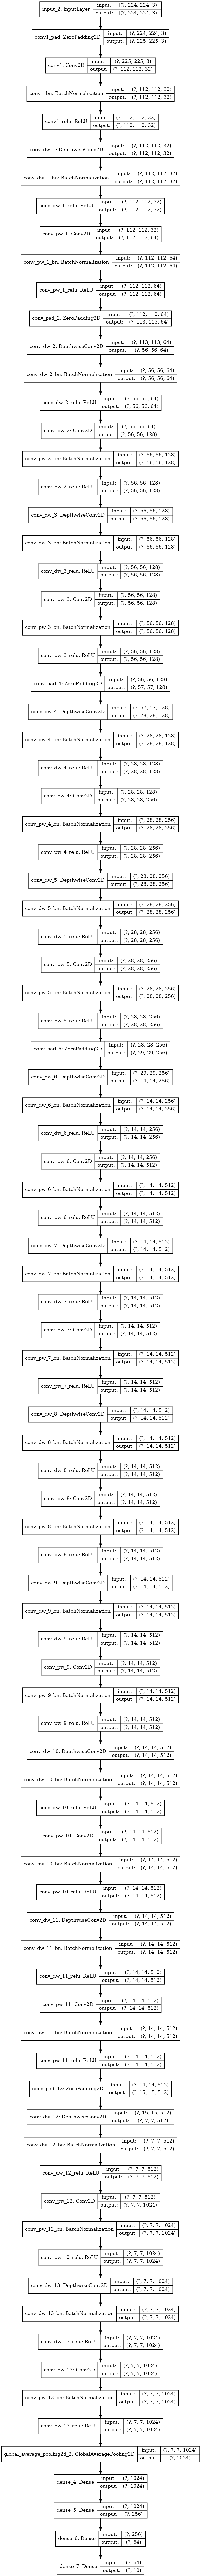

In [17]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file = 'model_images/mobile_net.png',
          show_shapes = True,
          show_layer_names = True)

## Loading the Monkey Breeds dataset

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = './monkey_breed/train'
val_data_dir = './monkey_breed/validation'

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 45, 
                                   width_shift_range = 0.4, 
                                   height_shift_range = 0.4, 
                                   horizontal_flip = True, 
                                   vertical_flip = True, 
                                   fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size = (rows, cols), 
                                                    batch_size = batch_size, 
                                                    class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory(val_data_dir, 
                                                    target_size = (rows, cols), 
                                                    batch_size = batch_size, 
                                                    class_mode = 'categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


## Training the Model

In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('monkey_breed_MobileNet.h5', 
                             monitor = 'val_loss', 
                             mode = 'min', 
                             save_best_only = True, 
                             verbose = 1)

callbacks = [checkpoint]

model.compile(loss = 'categorical_crossentropy', 
              optimizer = RMSprop(lr = 0.001), 
              metrics = ['accuracy'])

num_train_samples = 1098
num_val_samples = 272

epochs = 5
batch_size = 32

history = model.fit(train_generator, 
                              steps_per_epoch = num_train_samples//batch_size, 
                              epochs = epochs, 
                              callbacks = callbacks, 
                              validation_data = val_generator, 
                              validation_steps = num_val_samples//batch_size)

Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 0.8918 - accuracy: 0.7289
Epoch 00001: val_loss improved from inf to 0.33650, saving model to monkey_breed_MobileNet.h5
34/34 [==============================] - 58s 2s/step - loss: 0.8918 - accuracy: 0.7289 - val_loss: 0.3365 - val_accuracy: 0.9102
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.7805
Epoch 00002: val_loss improved from 0.33650 to 0.25191, saving model to monkey_breed_MobileNet.h5
34/34 [==============================] - 59s 2s/step - loss: 0.5964 - accuracy: 0.7805 - val_loss: 0.2519 - val_accuracy: 0.9375
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.8105
Epoch 00003: val_loss improved from 0.25191 to 0.20869, saving model to monkey_breed_MobileNet.h5
34/34 [==============================] - 58s 2s/step - loss: 0.5537 - accuracy: 0.8105 - val_loss: 0.2087 - val_accuracy: 0.9297
Epoch 4/5
34/34 [===========================